[A] φ=relu    α=0.01    b=8   val=0.5508  test=2.1201
[A] φ=relu    α=0.01    b=16  val=0.4981  test=1.8555
[A] φ=relu    α=0.01    b=32  val=0.5559  test=2.1557
[A] φ=relu    α=0.001   b=8   val=0.5969  test=2.4917
[A] φ=relu    α=0.001   b=16  val=0.7484  test=2.5785
[A] φ=relu    α=0.001   b=32  val=0.8907  test=2.8325
[A] φ=relu    α=0.0001  b=8   val=1.8393  test=3.8282
[A] φ=relu    α=0.0001  b=16  val=2.2018  test=4.2333
[A] φ=relu    α=0.0001  b=32  val=2.3825  test=4.4420
[A] φ=sigmoid α=0.01    b=8   val=0.5719  test=2.8588
[A] φ=sigmoid α=0.01    b=16  val=0.6350  test=2.6426
[A] φ=sigmoid α=0.01    b=32  val=1.0781  test=2.0973
[A] φ=sigmoid α=0.001   b=8   val=0.9480  test=2.2908
[A] φ=sigmoid α=0.001   b=16  val=0.9692  test=2.3643
[A] φ=sigmoid α=0.001   b=32  val=0.9704  test=2.4709
[A] φ=sigmoid α=0.0001  b=8   val=0.9531  test=2.3728
[A] φ=sigmoid α=0.0001  b=16  val=0.9408  test=2.3365
[A] φ=sigmoid α=0.0001  b=32  val=0.9788  test=2.4129
[B] φ=relu    α=0.01    b=8 

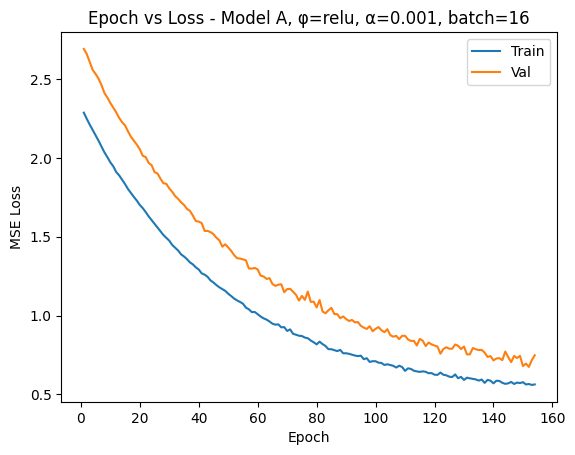

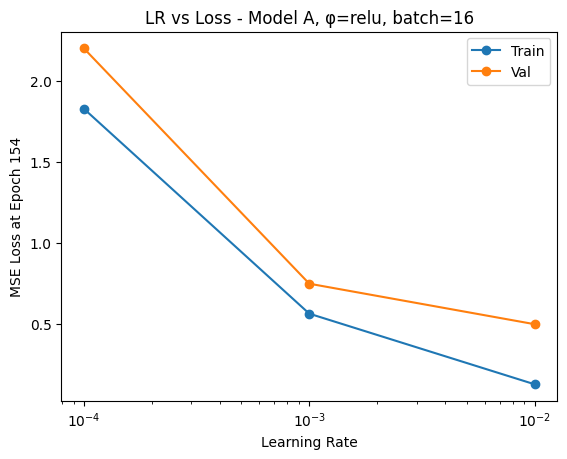

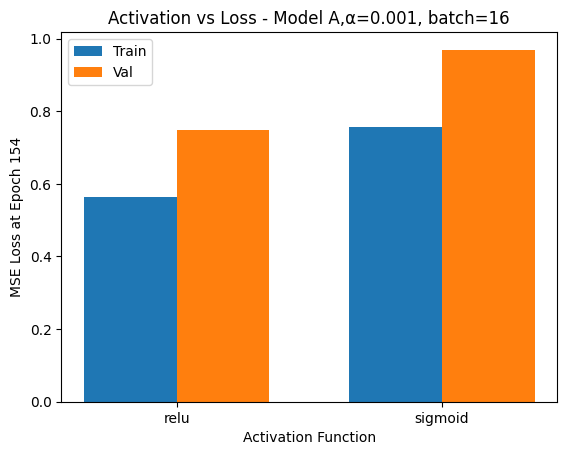

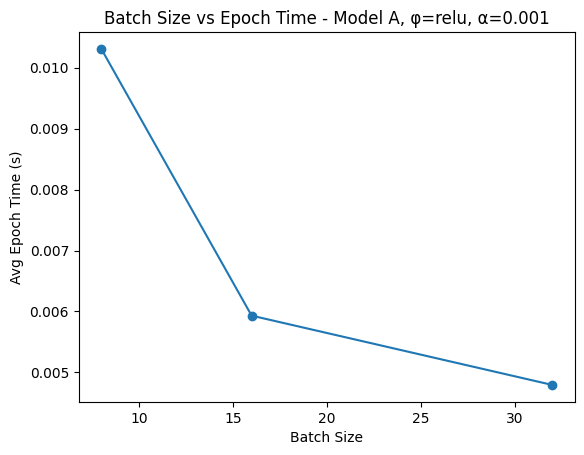

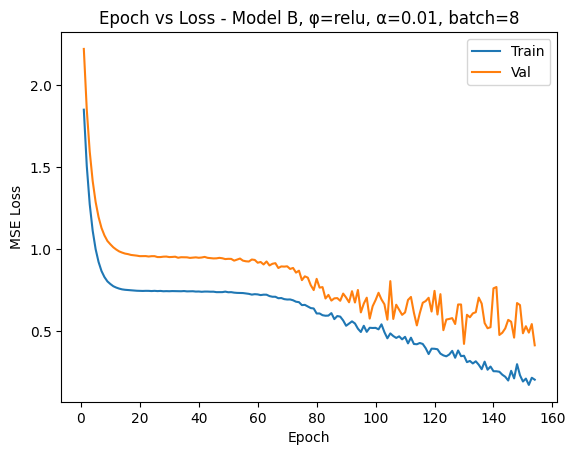

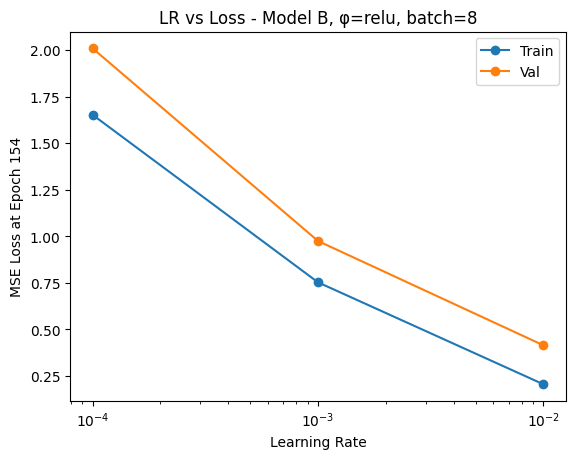

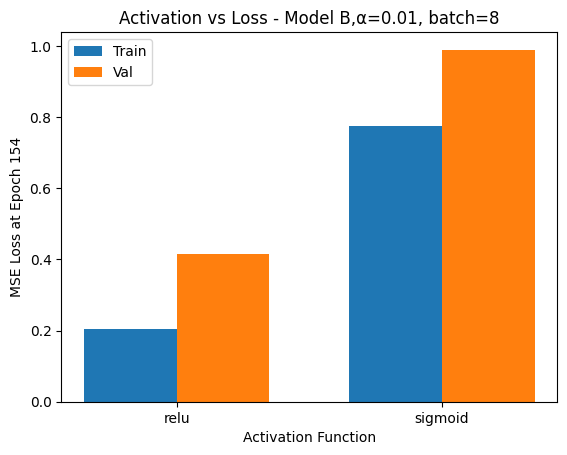

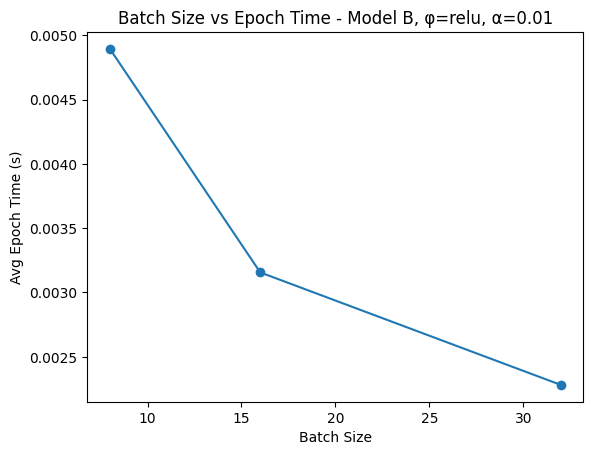

In [18]:
# Notebook Setup
# Title: Assignment 3 Intelligent Agents
# Topic: Predicting Mapping Penalties with a From-Scratch - ANN
#        Task and Employee assignment with 2 neural networks
# Name: Michael Durkan
# ID: 17378383

# Imports
import json
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt

# Load/Generate Data
from google.colab import files
uploaded = files.upload()

tasks = [
    {"id": "T1",  "time": 4, "difficulty": 3, "deadline":  8, "skill": "A"},
    {"id": "T2",  "time": 6, "difficulty": 5, "deadline": 12, "skill": "B"},
    {"id": "T3",  "time": 2, "difficulty": 2, "deadline":  6, "skill": "A"},
    {"id": "T4",  "time": 5, "difficulty": 4, "deadline": 10, "skill": "C"},
    {"id": "T5",  "time": 3, "difficulty": 1, "deadline":  7, "skill": "A"},
    {"id": "T6",  "time": 8, "difficulty": 6, "deadline": 15, "skill": "B"},
    {"id": "T7",  "time": 4, "difficulty": 3, "deadline":  9, "skill": "C"},
    {"id": "T8",  "time": 7, "difficulty": 5, "deadline": 14, "skill": "B"},
    {"id": "T9",  "time": 2, "difficulty": 2, "deadline":  5, "skill": "A"},
    {"id": "T10", "time": 6, "difficulty": 4, "deadline": 11, "skill": "C"},
]

employees = [
    {"id": "E1", "hours": 10, "level": 4, "skills": ["A", "C"]},
    {"id": "E2", "hours": 12, "level": 6, "skills": ["A", "B", "C"]},
    {"id": "E3", "hours":  8, "level": 3, "skills": ["A"]},
    {"id": "E4", "hours": 15, "level": 7, "skills": ["B", "C"]},
    {"id": "E5", "hours":  9, "level": 5, "skills": ["A", "C"]},
]

taskId     = {task["id"]: task for task in tasks}
employeeId = {employee["id"]: employee for employee in employees}
skillIdx = {"A": 0, "B": 1, "C": 2}

# Preprocessing
# Create One hot skills
def one_hot_skill(skillSym):
    vec = [0, 0, 0]
    vec[skillIdx[skillSym]] = 1
    return vec
# Create one hot skill set
def one_hot_skill_set(skillList):
    vec = [0, 0, 0]
    for skill in skillList:
        vec[skillIdx[skill]] = 1
    return vec
# Group features together
def pair_features(task, emp):
    return ( [task["time"], task["difficulty"], task["deadline"]] + one_hot_skill(task["skill"])
        + [emp["hours"], emp["level"]] + one_hot_skill_set(emp["skills"]))

# Construct the input vector from features
def construct_i_vector(empIds):
    vec = []
    for i, empId in enumerate(empIds, start=1):
        task = taskId[f"T{i}"]
        emp  = employeeId[empId]
        vec.extend(pair_features(task, emp))
    return vec

# Read the mappings csv
dfMap = pd.read_csv("mappings.csv")

# Create X and y list from the mapping
X_list, y_list = [], []
for i, row in dfMap.iterrows():
    empCols = row.iloc[:10].tolist()
    X_list.append(construct_i_vector(empCols))
    y_list.append(float(row["Penalty"]))

X = np.array(X_list, dtype=float)
y = np.array(y_list, dtype=float).reshape(-1,1)

N, n_x = X.shape    # Unpack data matrix to find its shape

# Seed for reproducibility of randomness
np.random.seed(42)

# Dropout keep probability
keep_prob = 0.67

#Hyper parameters
ALPHAS = [0.01, 0.001, 0.0001]    # Learning rate
BATCHES = [8, 16, 32]             # mini-batch size
ACTIVATIONS = ["relu", "sigmoid"] # activation functions
MODELS = ["A", "B"]
EPOCHS = 154

# Activation functions / derivatives
def sigmoid(z):
    return 1.0 / (1.0 + np.exp( -z))

def sigmoid_prime(z):
    a = sigmoid(z)
    return a * (1.0 - a)

def relu(z):
    return np.maximum(0.0, z)

def relu_prime(z):
    return (z > 0).astype(float)

# Weight init functions
def gaussian_init(shape):
    return np.random.randn(*shape) * 0.01

# Model Definitions
# Forward-Back propagations for Model A
def forward_prop_A(x):
    global W1, b1, W2, b2, act
    Z1 = W1 @ x + b1                # Find hidden pre-activation
    A1 = act(Z1)                    # Process activation

    # Create and apply dropout mask
    mask = (np.random.rand(*A1.shape) < keep_prob) / keep_prob
    A1 *= mask

    # Find linear output and store data in cache
    y_hat = W2 @ A1 + b2
    cache = (Z1, A1, mask, y_hat)

    return y_hat, cache

def back_prop_A(x, y_true, cache):
    global W1, b1, W2, b2, dact
    m = y_true.shape[1]         # Size of batch
    Z1, A1, mask, y_hat = cache # Unpack data in cache

    dZ2 = (2 * (y_hat - y_true)) / m # Derivative of loss function with respect to networks output

    dW2 = dZ2 @ A1.T            # Gradient of loss with respect to W2
    db2 = np.sum(dZ2, axis=1, keepdims=True) # Gradient of loss with respect to b2

    dA1 = W2.T @ dZ2            # Backpropogate to hidden layer
    dA1 *= mask

    dZ1 = dA1 * dact(Z1)        # Gradient of loss with respect to hidden pre activation


    dW1 = dZ1 @ x.T             # Grad loss to W1
    db1 = np.sum(dZ1, axis=1, keepdims=True) # Grad loss to b1

    return dW1, db1, dW2, db2

# Forward-Back Propagations for Model B
def forward_prop_B(x):
    global W1, b1, W2, b2, W3, b3, act
    Z1 = W1 @ x + b1    # Hidden1 pre activation
    A1 = act(Z1)        # Hidden1 activation
    mask1 = (np.random.rand(*A1.shape) < keep_prob) / keep_prob # create dropout 1
    A1 *= mask1

    Z2 = W2 @ A1 + b2   # Hidden2 pre activation
    A2 = act(Z2)        # Hidden2 activation
    mask2 = (np.random.rand(*A2.shape) < keep_prob) / keep_prob # create dropout 2
    A2 *= mask2

    y_hat = W3 @ A2 + b3 # output pre activation
    cache = (Z1, A1, mask1, Z2, A2, mask2, y_hat)

    return y_hat, cache

def back_prop_B(x,y_true, cache):
    global W1, b1, W2, b2, W3, b3, dact
    m = y_true.shape[1] # Size of batch
    Z1, A1, mask1, Z2, A2, mask2, y_hat = cache

    dZ3 = (2 * (y_hat - y_true)) / m # Gradient of output layer

    dW3 = dZ3 @ A2.T  # Grad loss to W3
    db3 = np.sum(dZ3, axis=1, keepdims=True) # Grad loss to b3

    dA2 = W3.T @ dZ3  # Backpropagation to second hidden layer
    dA2 *= mask2 # dropout of second layer
    dZ2 = dA2 * dact(Z2) # Gradient hidden2 pre activation

    dW2 = dZ2 @ A1.T
    db2 = np.sum(dZ2, axis=1, keepdims=True)

    dA1 = W2.T @ dZ2  # Backpropagation to first hidden
    dA1 *= mask1 # dropout of first layer
    dZ1 = dA1 * dact(Z1)

    dW1 = dZ1 @ x.T
    db1 = np.sum(dZ1, axis = 1, keepdims=True)

    return dW1, db1, dW2, db2, dW3, db3

# Data Splitting
idx_train, idx_val, idx_test = slice(0,70), slice(70,85), slice(85,100)
X_train, y_train = X[idx_train], y[idx_train]
X_val, y_val = X[idx_val], y[idx_val]
X_test, y_test = X[idx_test], y[idx_test]

# Z score normalize on training data

mu = X_train.mean(axis=0, keepdims=True) # Find mean
sigma = X_train.std(axis=0, keepdims=True) # Find stdev
sigma[sigma == 0] = 1.0                 # Stop divide zero
# Normalize the data
X_train = (X_train - mu) / sigma
X_val = (X_val - mu) / sigma
X_test = (X_test - mu) / sigma

# Mean squared error
def mse(y_hat, y_true):
    return np.mean((y_hat - y_true)**2)

# Training Loop

results = {}
for MODEL in MODELS:
    for phi in ACTIVATIONS:
        init = gaussian_init

        # Decide activation, derivate and forward-back functions
        if phi == "relu":
            act = relu
            dact = relu_prime
        else:
            act = sigmoid
            dact = sigmoid_prime

        if MODEL == "A":
            fwd, back = forward_prop_A, back_prop_A
        else:
            fwd, back = forward_prop_B, back_prop_B

        for alpha in ALPHAS:
            for bsz in BATCHES:
                # Re initialize biases/weights
                if MODEL == "A":
                    W1 = init((256, n_x))
                    b1 = np.zeros((256, 1))
                    W2 = init(( 1, 256))
                    b2 = np.zeros((1,1))
                else:
                    W1 = init((128, n_x))
                    b1 = np.zeros((128, 1))
                    W2 = init((128, 128))
                    b2 = np.zeros((128,1))
                    W3 = init(( 1, 128))
                    b3 = np.zeros((1, 1))

                Ltr, Lval, Tepoch = [], [], []   # Keep history

                for ep in range(EPOCHS):
                    t0 = time.perf_counter()     # Start Timer
                    # Shuffle the training data
                    perm = np.random.permutation(len(X_train))
                    Xt, yt = X_train[perm], y_train[perm]
                    # Loop for mini batches
                    for i in range(0, len(Xt), bsz):
                        xb = Xt[i:i+bsz].T       # Batch features
                        yb = yt[i:i+bsz].T       # Batch Targets
                        y_hat, cache = fwd(xb)   # Forward pass
                        grads = back(xb, yb, cache) # Backward pass
                        lam = 0.005              # L2 weight decay

                        # Update the mini-batch gradient descent
                        if MODEL == "A":
                            dW1, db1_, dW2, db2_ = grads
                            dW1 += lam * W1
                            dW2 += lam * W2
                            W1 -= alpha * dW1
                            b1 -= alpha * db1_
                            W2 -= alpha * dW2
                            b2 -= alpha * db2_
                        else:
                            dW1, db1_, dW2, db2_, dW3, db3_ = grads
                            dW1 += lam * W1
                            dW2 += lam * W2
                            dW3 += lam * W3

                            W1 -= alpha * dW1
                            b1 -= alpha * db1_
                            W2 -= alpha * dW2
                            b2 -= alpha * db2_
                            W3 -= alpha * dW3
                            b3 -= alpha * db3_

                    Tepoch.append(time.perf_counter() - t0) # Record epoch time

                    # Train loss
                    ytr, _ = fwd(X_train.T)
                    Ltr.append(mse(ytr, y_train.T))
                    # Val loss
                    yv, _ = fwd(X_val.T)
                    Lval.append(mse(yv, y_val.T))

                # Evaluate test
                yte, _ = fwd(X_test.T)
                Ltest = mse(yte, y_test.T)

                # Store results
                results[(MODEL, alpha, bsz, phi)] = {
                    "train": Ltr,
                    "val": Lval,
                    "epoch_time" : Tepoch,
                    "test": Ltest
                }

                # Output results
                print(f"[{MODEL}] φ={phi:7s} α={alpha:<7} b={bsz:<2}  "
                  f"val={Lval[-1]:.4f}  test={Ltest:.4f}")

# Evaluation and Plotting
# Change the variables at top to have different graph outputs
# 1.A Epoch vs Loss

model = "A"
alpha = 0.001
bsz = 16
phi = "relu"
key = (model, alpha, bsz, phi)

train_loss = results[key]["train"]
val_loss = results[key]["val"]
epochs = list(range(1, len(train_loss) + 1))

plt.figure()
plt.plot(epochs, train_loss, label ="Train") # Curve train
plt.plot(epochs, val_loss, label ="Val")     # Curve val
# Place labels
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
# Write title
plt.title(f"Epoch vs Loss - Model {model}, φ={phi}, α={alpha}, batch={bsz}")
plt.legend()
plt.savefig("A_epochVloss.png", dpi=150, bbox_inches="tight")
plt.show()

# 2.A Learning rate vs loss

e_star = -1   # idx of last epoch
bsz_fixed = 16 # fixed batch size
phi_fixed = "relu" # fixed activation
model = "A"     # fixed model

rates = ALPHAS
train_at_e = [ results[(model, r, bsz_fixed, phi_fixed)]["train"][e_star] for r in rates]
val_at_e = [ results[(model, r, bsz_fixed, phi_fixed)]["val"][e_star] for r in rates]

plt.figure()
plt.semilogx(rates, train_at_e, marker = "o", label = "Train")
plt.semilogx(rates, val_at_e, marker = "o", label = "Val")
plt.xlabel("Learning Rate")
plt.ylabel(f"MSE Loss at Epoch 154")
plt.title(f"LR vs Loss - Model {model}, φ={phi_fixed}, batch={bsz_fixed}")
plt.legend()
plt.savefig("A_learnVloss.png", dpi=150, bbox_inches="tight")
plt.show()

# 3.A Activation Function vs Loss

e_star = -1
alpha_fix = 0.001
bsz_fix = 16
model = "A"

acts = ACTIVATIONS
train_act = [results[(model, alpha_fix, bsz_fix, act)]["train"][e_star] for act in acts]
val_act = [results[(model, alpha_fix, bsz_fix, act)]["val"][e_star] for act in acts]

x = range(len(acts))
width = 0.35

plt.figure()
plt.bar(x, train_act, width, label="Train")
plt.bar([i+width for i in x], val_act, width, label="Val")
plt.xticks([i+width/2 for i in x], acts)
plt.xlabel("Activation Function")
plt.ylabel(f"MSE Loss at Epoch 154")
plt.title(f"Activation vs Loss - Model {model},α={alpha_fix}, batch={bsz_fix}")
plt.legend()
plt.savefig("A_actVloss.png", dpi=150, bbox_inches="tight")
plt.show()

# 4.A Batch Size vs Average Epoch Time
model = "A"
alpha_fix = 0.001
phi_fix = "relu"

bszs = BATCHES
avg_times = [np.mean(results[(model, alpha_fix, b, phi_fix)]["epoch_time"]) for b in bszs]

plt.figure()
plt.plot(bszs, avg_times, marker = "o")
plt.xlabel("Batch Size")
plt.ylabel("Avg Epoch Time (s)")
plt.title(f"Batch Size vs Epoch Time - Model {model}, φ={phi_fix}, α={alpha_fix}")
plt.savefig("A_batchVepoch.png", dpi=150, bbox_inches="tight")
plt.show()

# 1.B Epoch vs Loss

model = "B"
alpha = 0.01
bsz = 8
phi = "relu"
key = (model, alpha, bsz, phi)

train_loss = results[key]["train"]
val_loss = results[key]["val"]
epochs = list(range(1, len(train_loss) + 1))

plt.figure()
plt.plot(epochs, train_loss, label ="Train") # Curve train
plt.plot(epochs, val_loss, label ="Val")     # Curve val
# Place labels
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
# Write title
plt.title(f"Epoch vs Loss - Model {model}, φ={phi}, α={alpha}, batch={bsz}")
plt.legend()
plt.savefig("B_epochVloss.png", dpi=150, bbox_inches="tight")
plt.show()

# 2.B Learning rate vs loss

e_star = -1   # idx of last epoch
bsz_fixed = 8 # fixed batch size
phi_fixed = "relu" # fixed activation
model = "B"     # fixed model

rates = ALPHAS
train_at_e = [ results[(model, r, bsz_fixed, phi_fixed)]["train"][e_star] for r in rates]
val_at_e = [ results[(model, r, bsz_fixed, phi_fixed)]["val"][e_star] for r in rates]

plt.figure()
plt.semilogx(rates, train_at_e, marker = "o", label = "Train")
plt.semilogx(rates, val_at_e, marker = "o", label = "Val")
plt.xlabel("Learning Rate")
plt.ylabel(f"MSE Loss at Epoch 154")
plt.title(f"LR vs Loss - Model {model}, φ={phi_fixed}, batch={bsz_fixed}")
plt.legend()
plt.savefig("B_learnVloss.png", dpi=150, bbox_inches="tight")
plt.show()

# 3.B Activation Function vs Loss

e_star = -1
alpha_fix = 0.01
bsz_fix = 8
model = "B"

acts = ACTIVATIONS
train_act = [results[(model, alpha_fix, bsz_fix, act)]["train"][e_star] for act in acts]
val_act = [results[(model, alpha_fix, bsz_fix, act)]["val"][e_star] for act in acts]

x = range(len(acts))
width = 0.35

plt.figure()
plt.bar(x, train_act, width, label="Train")
plt.bar([i+width for i in x], val_act, width, label="Val")
plt.xticks([i+width/2 for i in x], acts)
plt.xlabel("Activation Function")
plt.ylabel(f"MSE Loss at Epoch 154")
plt.title(f"Activation vs Loss - Model {model},α={alpha_fix}, batch={bsz_fix}")
plt.legend()
plt.savefig("B_actVloss.png", dpi=150, bbox_inches="tight")
plt.show()

# 4.B Batch Size vs Average Epoch Time
model = "B"
alpha_fix = 0.01
phi_fix = "relu"

bszs = BATCHES
avg_times = [np.mean(results[(model, alpha_fix, b, phi_fix)]["epoch_time"]) for b in bszs]

plt.figure()
plt.plot(bszs, avg_times, marker = "o")
plt.xlabel("Batch Size")
plt.ylabel("Avg Epoch Time (s)")
plt.title(f"Batch Size vs Epoch Time - Model {model}, φ={phi_fix}, α={alpha_fix}")
plt.savefig("B_batchVepoch.png", dpi=150, bbox_inches="tight")
plt.show()